# **Composición mensual de la demanda de gas por tipo de usuario**


---



La evolución de la demanda de gas natural refleja -o, incluso, anticipa- las fluctuaciones de la actividad económica. Asimismo, la desagregación según el tipo de usuario permite discernir la razón que opera por detrás de los aumentos o disminuciones de la demanda. Por ello, este indicador resulta fundamental como herramienta de análisis económico.

El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos de la demanda de gas natural según el tipo de usuario, desde el año 2013.

Como resultado del análisis de datos, se presenta una figura en forma de gráfico de área apilada, que permite visualizar la evolución de la demanda para cada tipo de usuario.

## Preliminar

### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import plotly.graph_objects as go
import datetime as dt
import plotly.io as pio

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [2]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.2 MB/s eta 0:00:00


## Obtención y limpieza de datos

El Ente Nacional Regulador del Gas (ENARGAS), en forma de cuadros divididos por año publica mensualmente cuadros en los que cuantifica la demanda de gas natural para cada tipo de usuario.

El difícil acceso a dichos cuadros, sumado a la imposibilidad de sistematización del proceso de extracción de datos, hacen necesario buscar vías alternativas para obtenerlos.

### Demanda de gas natural hasta 2021

En particular, dentro de los Datos Abiertos de ENARGAS, la información deseada puede encontrarse en la siguiente *ruta*:

*   Transporte y Distribución
   *   Datos operativos de Transporte y Distribución de Gas
      3. Datos Operativos de Gas Natural: Total Sistema
         02. Gas Entregado, por Tipo de Usuario

La API de Series de Tiempo del portal de Datos Argentina (Datos Abiertos de la República Argentina, https://datos.gob.ar) permite consultar indicadores con evolución en el tiempo.

La documentación de dicha API puede encontrarse en: https://datosgobar.github.io/series-tiempo-ar-api/

Para utilizarla, primeramente, se eligen los *datasets* (o series de tiempo) deseadas. Cada serie de tiempo está representada por un *id* único.

En particular, son de relevancia las series de tiempo de las cantidades demandadas de gas natural por cada tipo de usuario. Por ello, la lista `ids` contiene el *id* correspondiente a cada tipo de usuario.

In [3]:
ids = [
  "364.3_RESIDENCIAIAL__11", 
  "364.3_COMERCIALIAL__9",
  "364.3_ENTES_OFICLES__15",
  "364.3_INDUSTRIARIA__9",
  "364.3_CENTRALES_CAS__20",
  "364.3_SDBSDB__3",
  "364.3_GNCGNC__3"
]

Dado que la API permite efectuar consultas combinadas, evitando iteraciones innecesarias, se concatenan los elementos de la lista `ids`, separados por una coma (`,`) en una sola cadena de texto (`string`).

Así, `ids` contendrá cada uno de los identificadores de los *datasets* a examinar, separados por una coma.

In [4]:
ids = ",".join(map(str, ids))

La API precisa, asimismo, los años de comienzo y final de análisis, como cadena de texto.

Se *setea*, arbitrariamente, el comienzo del análisis en el año 2013. Por falta de continuidad de la serie de tiempo, se setea como año de finalización del análisis al año 2021.

In [5]:
start = "2013"

In [6]:
end = "2021"

A partir de los valores definidos en `ids`, en `start` y en `end`, se crea una `f-string` (`url_api_call`) que funcione para hacer un *call* a la API antes mencionada.

`url_api_call` devolverá un archivo `.csv` (dado que `&format=csv`) que contiene los valores de los *datasets* identificados en `ids` a partir del año especificado en `start` y hasta el año especificado en `end`.

In [7]:
url_api_call = f"https://apis.datos.gob.ar/series/api/series/?ids={ids}&start_date={start}&end_date={end}&limit=5000&format=csv"

De esta manera, a partir de `url_api_call`, se puede generar el *call* a la API directamente desde un *DataFrame* creado en `pandas` con el comando `read_csv`. Así, se crea el *DataFrame* `demanda_2013_2021`, que contiene los datos de las cantidades demandadas por cada tipo de usuario, desde enero del año 2013 hasta diciembre del año 2021.

In [8]:
demanda_2013_2021 = pd.read_csv(url_api_call)

La columna "indice_tiempo" funciona como índice temporal. Por tanto, se lo transforma en formato `datetime` y se cambia su formato, ubicando primero los días del mes.

In [9]:
demanda_2013_2021["indice_tiempo"] = pd.to_datetime(demanda_2013_2021["indice_tiempo"], dayfirst=True)

Los datos publicados en el Portal de Datos Abiertos están expresados en millones de m<sup>3</sup>. Se multiplica el valor de cada columna por 1000 para transformar su unidad de medida a miles de m<sup>3</sup>.

In [10]:
for column in demanda_2013_2021.columns[1:]:
  demanda_2013_2021[column] = demanda_2013_2021[column] * 1000

### Demanda de gas natural a partir de 2022

Ahora bien, el *DataFrame* `demanda_2013_2021` contiene datos hasta diciembre del año 2021.

Dado que la serie de tiempo publicada en los Datos Abiertos no tuvo continuidad a lo largo del año 2022, los datos a partir de diciembre del año 2021 deben obtenerse directamente desde los cuadros de ENARGAS.

En este sentido, `url_2022` refiere al último archivo de los Datos Operativos de Gas Natural (Total Sistema) publicado por ENARGAS, en el que se cuantifica el gas entregado por tipo de usuario.

In [11]:
url_2022 = "https://www.enargas.gob.ar/secciones/transporte-y-distribucion/ajax/datos-operativos-exporta.php?tipo=pdf&anio=%20=%202022&planilla=0302010-Cuadro_III_1"

Sin embargo, la lectura de dicho archivo debe realizarse a través de una `Request` a la página. Este pedido es "abierto" con `urlopen()` y, luego, se buscan y adjuntan las tablas que aparezcan en la página.

Para simplificar la escritura, se crea una función, `request_gas`, que -utilizando `Request` y `BeautifulSoup`, extrae una lista con los datos requeridos. 

Los parámetros de esta función son:


*   `url`: un link de una página web válida.
*   `data`: una lista vacía donde almacenar los datos.



In [12]:
def request_gas(url, data):
  req = Request(
    url,
  )
  page = urlopen(req)
  html_parser = BeautifulSoup(page, "lxml")
  tables = html_parser.findAll('tr')
  for tr in tables:
    row_data = []
    for td in tr.findAll('td'):
      row_data.append(td.text)
    data.append(row_data)
  return data

En el caso de la demanda de gas natural en el año 2022, se crea la lista vacía `demanda_2022_data`.

In [13]:
demanda_2022_data = []

Se actualiza dicha tabla a partir de la función `request_gas`, con los parámetros antes definidos.

In [14]:
demanda_2022_data = request_gas(url_2022, demanda_2022_data)

El contenido de la lista `demanda_2022_data` se transforma en un *DataFrame* -mediante `pd.DataFrame()`- que toma como nombre `demanda_2022`.

In [15]:
demanda_2022 = pd.DataFrame(demanda_2022_data)

A partir del *DataFrame* `demanda_2022`, se eliminan ciertas columnas y filas.

In [16]:
demanda_2022 = demanda_2022.drop([2, 4, 6, 8, 10, 12, 14, 15], axis=1)[1:-2].reset_index(drop=True)

Los valores en `demanda_2022` son interpretados como cadenas de texto (`string`). Se actualiza su *type* mediante el comand `astype()`, siendo éste actualizado a `float`.

In [17]:
for column in demanda_2022.columns[1:]:
  demanda_2022[column] = demanda_2022[column].astype(float)

Se renombran las columnas del *DataFrame* `demanda_2022` utilizando las columnas del *DataFrame* `demanda_2013_2021`.

In [18]:
demanda_2022.columns = demanda_2013_2021.columns

Por último, se actualiza la columna "indice_tiempo": dado que no posee información sobre el año, se genera un `date_range` que comienza en enero del año 2022 y tiene una longitud igual a la cantidad de meses del *DataFrame* `demanda_2022`. Se utiliza la frecuencia `MS` para indicar que cada valor en el rango debe indicar el comienzo de un mes ("Month-Start").

In [19]:
demanda_2022["indice_tiempo"] = pd.date_range(start='1/1/2022', periods=len(demanda_2022), freq="MS")

## *DataFrame* final

Los valores de la demanda de gas natural por tipo de usuario se encuentran, entonces, separados:


*   El *DataFrame* `demanda_2013_2021` contiene la información desde enero del año 2013 hasta diciembre del año 2021.
*   El *DataFrame* `demanda_2022` contiene la información desde enero del año 2022 hasta la actualidad.

Ambos archivos se concatenan verticalmente en un solo *DataFrame* denominado `demanda`.

In [20]:
demanda = pd.concat([demanda_2013_2021, demanda_2022]).reset_index(drop=True)

Finalmente, los valores de algunas columnas pueden agruparse. En particular, se crea la columna "comercial + sdb + entes_oficiales" que, como su nombre lo indica, refleja la suma de dichas 3 columnas. Luego, se eliminan las columnas innecesarias.

In [21]:
demanda["comercial + sdb + entes_oficiales"] = demanda["comercial"] + demanda["sdb"] + demanda["entes_oficiales"]

In [22]:
demanda = demanda.drop(["comercial", "sdb", "entes_oficiales"], axis=1)

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [23]:
demanda.head()

,indice_tiempo,residencial,industria,centrales_electricas,gnc,comercial + sdb + entes_oficiales
0,2013-01-01,275471.0,1061954.0,1718916.0,218695.0,128402.0
1,2013-02-01,280520.0,970621.0,1538652.0,201606.0,122207.0
2,2013-03-01,470709.0,1115484.0,1373569.0,230873.0,150663.0
3,2013-04-01,550480.0,1114318.0,1315524.0,219804.0,172006.0
4,2013-05-01,1163970.0,1084288.0,1017533.0,232878.0,287486.0


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [24]:
demanda.to_excel("Demanda de gas natural por tipo de usuario.xlsx", index=False)

## Figura: Composición mensual de la demanda de gas por tipo de usuario

Al tratarse de una sola figura, en este caso, no es necesario definir una función, sino que las especificaciones de la figura se encuentran en el argumento de ésta.

Sin embargo, resulta eficiente crear una función para modificar el aspecto de la figura en general. Así, la función `gas_update_layout` contiene el código necesario para esta visualización.

Sus parámetros son:
*   `fig`: el nombre de la figura a utilizar.
*   `df`: el *DataFrame* que contiene la información a graficar.
*   `min`: valor mínimo del eje de ordenadas.
*   `max`: valor máximo del eje de ordenadas.
*   `title_text`: título del eje de ordenadas.

In [25]:
def gas_update_layout(fig, df, min, max, title_text):
  fig.update_layout(
    plot_bgcolor = 'rgba(0,0,0,0)',
    margin = dict(
        b=15,
        t=15,
        l=15,
        r=60
    ),
    legend = dict(
        title = None,
        orientation = 'h',
        xanchor = 'center', 
        x = 0.5, 
        yanchor = 'bottom', 
        y = 1,
        font = dict(
            size = 16
        ),
        traceorder="normal"),
    height = 750,
    width = 1000,
    xaxis = dict(
        range = [df["indice_tiempo"][0], dt.date(df["indice_tiempo"][len(df)-1].year, df["indice_tiempo"][len(df)-1].month, 28)],
        title = None,
        tickformat = "%m\n<b>%Y",
        dtick = "M6",
        tickangle = 0
        ),
    yaxis = dict(
        range = [min, max],
        title = dict(
            text=title_text
            ),
        showgrid=True,
        gridcolor='lightgray'
        ),
    font = dict(
        size = 14,
        family = "serif"
        )
    )

Se establece un color para cada tipo de usuario.

In [26]:
colors_demanda = ['rgb(229, 134, 6)', 'rgb(93, 105, 177)', 'rgb(82, 188, 163)', 'rgb(153, 201, 69)', 'rgb(204, 97, 176)']

A los propósitos de una correcta visualización, se deben reordenar las columnas del *DataFrame* `demanda`.

Para no afectar directamente a dicho *DataFrame*, se crea una copia de éste llamada `demanda_viz`. Es sobre este último *DataFrame* que se reordenan las columnas.

In [27]:
demanda_viz = demanda.copy()

In [28]:
demanda_viz = demanda_viz[[demanda_viz.columns[0]] + [demanda_viz.columns[3]] +
                          [demanda_viz.columns[2]] + [demanda_viz.columns[1]] +
                          [demanda_viz.columns[4]] + [demanda_viz.columns[5]]
                          ]

En tanto, la variable `aggregate_demanda` es:


*   0 si el tipo de demanda es residencial
*   El valor de la suma de las demandas inmediatamente anteriores si el tipo de demanda no es residencial.



In [29]:
aggregate_demanda = []
for column, i in zip(demanda_viz.columns[1:], range(0, len(demanda_viz.columns[1:])+1)):
  if column == demanda_viz.columns[1]:
    aggregate_demanda.append(0)
  else:
    aggregate_demanda.append(demanda_viz[demanda_viz.columns[1:]].cumsum(axis=1).tail(1).values[0].tolist()[i] - demanda_viz[column][len(demanda_viz)-1])

Dado que las áreas deben estar apiladas, la lista `filling` contiene los valores para asegurar una correcta visualización.

In [30]:
filling = ["tozeroy"] + ["tonexty"]*4

Por último, se especifican los nombres de cada tipo de usuario.

In [31]:
names = ['Centrales Eléctricas', 'Industria', 'Residencial', 'GNC', 'Comercial + Subdistribuidoras + Entes Oficiales']

Se crea la figura `demanda_gas` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [32]:
demanda_gas = go.Figure()

Las especificaciones de la figura se encuentran en su argumento, y se hace uso de la función `gas_update_layout` para modificar el aspecto de la figura en general.

In [33]:
for tipo_usuario, name, color, agg, fill in zip(demanda_viz.columns[1:].tolist(), names, colors_demanda, aggregate_demanda, filling):
  demanda_gas.add_trace(
    go.Scatter(
      x = demanda_viz["indice_tiempo"],
      y = demanda_viz[tipo_usuario],
      mode = 'lines',
      name = name,
      line = dict(
          color = color
      ),
      fill = fill,
      stackgroup = 'one'
    )
  )
  demanda_gas.add_trace(
    go.Scatter(
      showlegend = False,
      name = tipo_usuario + " - EoP",
      mode = "markers",
      x = demanda_viz["indice_tiempo"].tail(1),
      y = demanda_viz[tipo_usuario].tail(1) + agg,
      marker = dict(color = color, size=10),
      )
    )
  demanda_gas.add_annotation(
    x = demanda_viz["indice_tiempo"][len(demanda_viz)-1],
    y = demanda_viz[tipo_usuario][-1:].values[0] + agg,
    text = str(round(demanda_viz[tipo_usuario][-1:].values[0]/1000000, 2)) + "M",
    font = dict(color = color),
    xanchor = "left",
    xshift = 5,
    yshift = 0,
    showarrow = False
    )

gas_update_layout(demanda_gas, demanda_viz, -25000, 4750000, "<b>Miles de m\u00b3")

A continuación, se exhibe la figura.

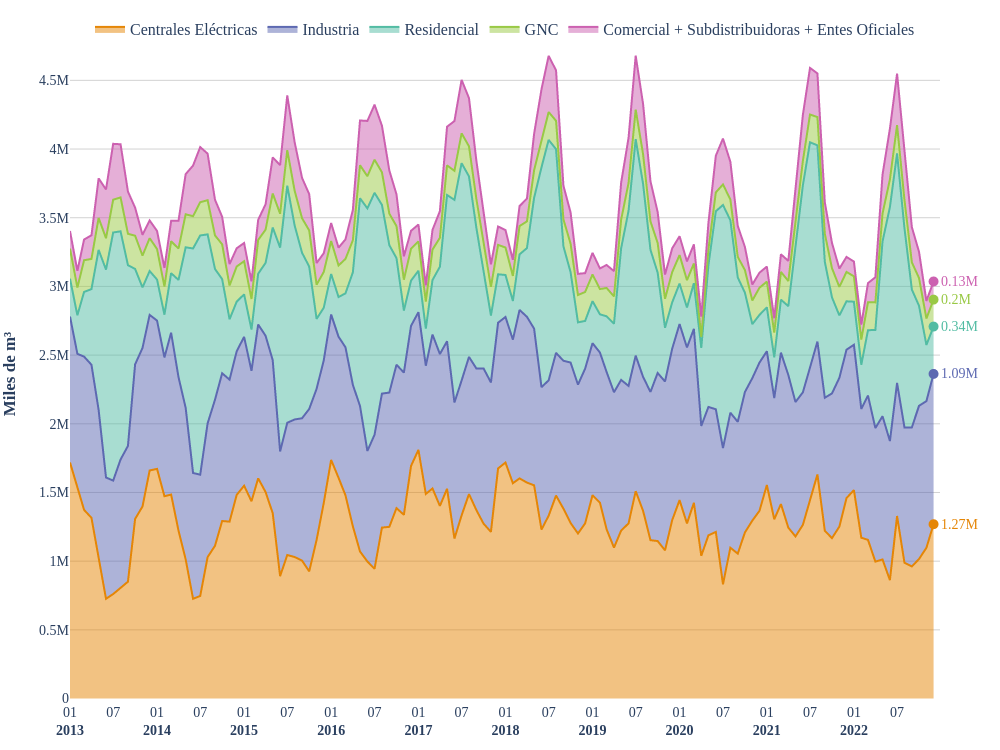

In [34]:
demanda_gas.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [35]:
pio.write_image(demanda_gas, "Figura Demanda Gas.pdf", width=3*300, height=2.25*300)